**Visual Graph Learning with GCN for Financial Forecasting: CNN-Based
OHLC Image Embeddings and Market Topology**

# **CODE 4 : GCN_Quantile_Model**

# 🛠️ Setup

In [ ]:
# @title Import packages

import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pickle as pkl
from collections import OrderedDict
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from copy import deepcopy
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
import seaborn as sns

In [ ]:
# @title Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 模型定義

In [ ]:
# @title GCN architecture

# --- 1. 修改後的 GraphNorm (支援 Structure-Aware) ---
class GraphNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(GraphNorm, self).__init__()
        self.eps = eps
        self.num_features = num_features
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.alpha = nn.Parameter(torch.zeros(num_features))

    def forward(self, x, adj=None):
        """
        x: (Batch, Nodes, Features)
        adj: (Batch, Nodes, Nodes) -> Optional, A_norm
        """

        # [關鍵修改] 如果有提供 Adjacency Matrix，先做平滑 (Smoothing)
        # 這意味著我們 Normalize 的對象是 "聚合後的鄰居特徵" 而不是 "節點自身特徵"
        if adj is not None:
            x = torch.bmm(adj, x)

        # 1. 計算每個 Graph 的 Mean
        mean = x.mean(dim=1, keepdim=True)

        # 2. 計算每個 Graph 的 Std
        var = x.var(dim=1, keepdim=True, unbiased=False)
        std = (var + self.eps).sqrt()

        # 3. Apply GraphNorm formula
        x_norm = (x - self.alpha * mean) / std

        # 4. Affine transformation
        return self.gamma * x_norm + self.beta

# --- 2. 修改後的 GraphConvLayer ---
class GraphConvLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_nodes=28, dropout=0.5, learn_graph_structure=True):
        super(GraphConvLayer, self).__init__()
        self.learn_graph_structure = learn_graph_structure

        self.linear = nn.Linear(in_dim, out_dim)

        # Norm 的輸入維度是 in_dim
        self.norm = GraphNorm(in_dim)

        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)

        if self.learn_graph_structure:
            self.lambda_param = nn.Parameter(torch.tensor(1.0))
        else:
            self.lambda_param = None

    def forward(self, X, A, predefined_A_norm=None):
        """
        Pre-Activation 順序:
        (Smooth Norm) -> Act -> (Dropout) -> GraphConv -> Linear
        """

        # --- A. 準備 Adjacency Matrix (為了 Norm 需要先算好 A_norm) ---
        # 注意：原本 A_norm 是在 Conv 步驟才算，現在要提早到 Norm 步驟算
        if self.learn_graph_structure:
            BATCH = A.shape[0]
            N = A.shape[1]
            I = torch.eye(N).to(A.device).unsqueeze(0).expand(BATCH, N, N)
            A_tilde = A + (self.lambda_param * I)
            D_tilde = torch.sum(A_tilde, dim=2)
            D_inv_sqrt = torch.pow(D_tilde, -0.5)
            D_inv_sqrt[torch.isinf(D_inv_sqrt)] = 0.0
            D_mat_inv_sqrt = torch.diag_embed(D_inv_sqrt)
            A_norm = torch.bmm(torch.bmm(D_mat_inv_sqrt, A_tilde), D_mat_inv_sqrt)
        else:
            assert predefined_A_norm is not None
            A_norm = predefined_A_norm

        # --- B. Pre-Activation (帶有 Structure 的 Norm) ---
        # [關鍵修改] 這裡將 A_norm 傳入 norm
        # 效果：X_inner = Norm(A_norm * X)
        X_inner = self.norm(X, adj=A_norm)

        X_inner = self.act(X_inner)
        X_inner = self.dropout(X_inner)

        # --- C. 卷積運算 (再次使用 A_norm) ---
        # 這裡會形成第二次聚合： H = A_norm * Act(Norm(A_norm * X))
        H = torch.bmm(A_norm, X_inner)

        # --- D. 線性變換 ---
        H = self.linear(H)

        return H, A_norm

# --- 3. 修改後的 GCNModel_Part2 ---
class GCNModel_Part2(nn.Module):
    def __init__(self,
            in_features=256,
            gcn_hidden1=256,
            gcn_hidden2=256,
            dropout=0.5):
        super(GCNModel_Part2, self).__init__()

        self.gcn1 = GraphConvLayer(in_features, gcn_hidden1, dropout=dropout, learn_graph_structure=True)
        self.gcn2 = GraphConvLayer(gcn_hidden1, gcn_hidden2, dropout=dropout, learn_graph_structure=False)

        self.final_norm = GraphNorm(gcn_hidden2)
        self.final_act = nn.GELU()
        self.final_dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(gcn_hidden2, 2)
        self.Softmax = nn.Softmax(dim=2)

    def forward(self, N_t, A_t):
        # Layer 1
        out1, A_norm = self.gcn1(N_t, A_t)
        x1 = N_t + out1

        # Layer 2
        # 注意：這裡傳入上一層算好的 A_norm
        out2, _ = self.gcn2(x1, A=None, predefined_A_norm=A_norm)
        x2 = x1 + out2

        # Final Processing
        # [選擇題] 最後的 Norm 是否也要乘 A_norm?
        # 通常分類前的 Norm 只看特徵分佈，不一定要再聚合。
        # 這裡保持 adj=None (只做標準特徵 Norm)，避免過度平滑。
        x_final = self.final_norm(x2, adj=None)
        x_final = self.final_act(x_final)
        x_final = self.final_dropout(x_final)

        logits = self.output_layer(x_final)
        probs = self.Softmax(logits)

        return probs

# 輔助函式

In [ ]:
# @title Setting of Model Training

def set_seed(seed=42):
    """固定所有隨機種子以確保實驗可重現"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果有多張 GPU
    # 確保卷積算法的確定性 (會稍微影響效能但保證結果一致)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"🌱 Random Seed Set to: {seed}")

def make_tensor_dataset_GCN(X_Nt, X_At, y, mode="top_k", top_k=9, threshold=0.003):
    y = y.copy()
    y.columns = ['TradeDate', 'Ticker', 'Return_5D']

    if mode == "top_k":
        y['rank'] = y.groupby('TradeDate')['Return_5D'].rank(ascending=False, method='first')
        y['label'] = (y['rank'] <= top_k).astype(int)
    elif mode == "threshold":
        y['label'] = (y['Return_5D'] >= threshold).astype(int)
    else:
        raise ValueError(f"未知的 mode: '{mode}'。請使用 'top_k' 或 'threshold'。")

    # 2. 取得維度資訊
    num_samples = X_Nt.shape[0]  # 例如 1388 (天數)
    num_nodes = X_Nt.shape[1]    # 例如 28 (股票數)

    # --- 關鍵修正 ---
    # 確保 y 的總行數等於 天數 * 股票數
    assert len(y) == num_samples * num_nodes, f"y的長度({len(y)}) 與 X推算的總節點數({num_samples}*{num_nodes}={num_samples*num_nodes}) 不符！"

    # 將 y 從 (38864,) 重塑為 (1388, 28)
    # 注意：這裡假設 y 的排序順序與 X_Nt 的股票順序是一致的 (通常是先排日期，再排股票)
    y_reshaped = y['label'].values.reshape(num_samples, num_nodes)

    X_Nt_tensor = torch.tensor(X_Nt, dtype=torch.float32)
    X_At_tensor = torch.tensor(X_At, dtype=torch.float32)
    y_tensor = torch.tensor(y_reshaped, dtype=torch.long)
    dataset = TensorDataset(X_Nt_tensor, X_At_tensor, y_tensor)
    return dataset

def loss_function(output, ground_truth, alpha):
    if output.dim() == 1:
        output = output.unsqueeze(1)
    if ground_truth.dim() == 1:
        ground_truth = ground_truth.unsqueeze(1)

    reg_loss = F.mse_loss(output, ground_truth)

    # broadcasting
    output_diff = output - output.t()
    gt_diff = ground_truth - ground_truth.t()

    rank_loss = F.relu(-output_diff * gt_diff).sum() / 2

    return reg_loss + alpha * rank_loss

def train_model_GCN(model, train_dataset, val_dataset,
                    num_epochs=30, patience=2,
                    learning_rate=1e-4, batch_size=16, weight_decay=1e-4, class_weights=[1.0, 19/9]):
    """
    適用於 GCN 的訓練流程，輸入為 (N_t, A_t)，輸出分類  結果。
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Loss & Optimizer
    weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
      optimizer,
      mode = 'min',       # 我們希望 Loss 越小越好
      factor = 0.8,       # 每次 Loss 卡住時，將 LR 減半 (乘以 0.8)
      patience = 4,      # 如果 Loss 在 2 個 Epoch 內沒改善，就降低 LR
      min_lr = 1e-6
      )

    history = {
        'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [], 'train_f1': [], 'train_auc': [],
        'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_auc': []
    }
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0
    # patience_counter = 0

    # --- Training loop ---
    for epoch in tqdm(range(num_epochs)):
        model.train()
        epoch_train_loss = 0.0
        train_labels, train_preds, train_probs = [], [], [] # 新增 train_probs

        for N_t_batch, A_t_batch, y_batch in train_loader:
            N_t_batch = N_t_batch.to(device)
            A_t_batch = A_t_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(N_t_batch, A_t_batch)   # forward
            loss = criterion(outputs.permute(0, 2, 1), y_batch)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            # 收集訓練預測結果
            preds = torch.argmax(outputs, dim=2)
            probs = outputs[:, :, 1] # 取得類別 1 的機率 (for AUC)
            train_labels.append(y_batch.cpu().numpy())
            train_preds.append(preds.cpu().numpy())
            train_probs.append(probs.detach().cpu().numpy())

        y_true_train = np.concatenate(train_labels).reshape(-1)
        y_pred_train = np.concatenate(train_preds).reshape(-1)
        y_prob_train = np.concatenate(train_probs).reshape(-1)

        # 計算訓練集指標
        avg_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_acc = accuracy_score(y_true_train, y_pred_train)
        epoch_train_precision = precision_score(y_true_train, y_pred_train, average='binary', zero_division=0)
        epoch_train_recall = recall_score(y_true_train, y_pred_train, average='binary', zero_division=0)
        epoch_train_f1 = f1_score(y_true_train, y_pred_train, average='binary', zero_division=0)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['train_precision'].append(epoch_train_precision)
        history['train_recall'].append(epoch_train_recall)
        history['train_f1'].append(epoch_train_f1)

        # 計算 AUC (避免只有一個類別報錯)
        try:
            history['train_auc'].append(roc_auc_score(y_true_train, y_prob_train))
        except ValueError:
            history['train_auc'].append(0.5)

        # --- Validation ---
        model.eval()
        epoch_val_loss = 0.0
        val_labels, val_preds, val_probs = [], [], []

        with torch.no_grad():
            for N_t_batch, A_t_batch, y_batch in val_loader:
                N_t_batch = N_t_batch.to(device)
                A_t_batch = A_t_batch.to(device)
                y_batch = y_batch.to(device)

                outputs = model(N_t_batch, A_t_batch)
                loss = criterion(outputs.permute(0, 2, 1), y_batch)
                epoch_val_loss += loss.item()

                # 收集驗證預測結果
                preds = torch.argmax(outputs, dim=2)
                probs = outputs[:, :, 1] # 取得類別 1 的機率 (for AUC)
                val_labels.append(y_batch.cpu().numpy())
                val_preds.append(preds.cpu().numpy())
                val_probs.append(probs.cpu().numpy())

        # 計算驗證集指標
        y_true_val = np.concatenate(val_labels).reshape(-1)
        y_pred_val = np.concatenate(val_preds).reshape(-1)
        y_prob_val = np.concatenate(val_probs).reshape(-1)

        avg_val_loss = epoch_val_loss / len(val_loader)
        epoch_val_acc = accuracy_score(y_true_val, y_pred_val)
        epoch_val_precision = precision_score(y_true_val, y_pred_val, average='binary', zero_division=0)
        epoch_val_recall = recall_score(y_true_val, y_pred_val, average='binary', zero_division=0)
        epoch_val_f1 = f1_score(y_true_val, y_pred_val, average='binary', zero_division=0)

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_precision'].append(epoch_val_precision)
        history['val_recall'].append(epoch_val_recall)
        history['val_f1'].append(epoch_val_f1)

        try:
            history['val_auc'].append(roc_auc_score(y_true_val, y_prob_val))
        except ValueError:
            history['val_auc'].append(0.5)

        # scheduler.step()
        scheduler.step(avg_val_loss)
        # --- Early Stopping ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = deepcopy(model.state_dict())
            # patience_counter = 0
            best_epoch = epoch

    # Load best model weights
    if best_model is not None:
      model.load_state_dict(best_model)
      print(f"Loaded best model from epoch {best_epoch+1} with Val Loss: {best_val_loss:.6f}")
    return model, history, best_epoch

In [ ]:
def plot_training_curves(history, best_epoch):
    """
    繪製訓練過程中的 Loss 和 Accuracy 曲線
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    epochs = range(1, len(history['train_loss']) + 1)

    # --- 圖 1: Loss 曲線 ---
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    # 標記最佳 Epoch
    ax1.axvline(best_epoch + 1, color='g', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    ax1.legend()
    ax1.grid(True)

    # --- 圖 2: Accuracy 曲線 ---
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    ax2.set_title('Training & Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    # 標記最佳 Epoch
    ax2.axvline(best_epoch + 1, color='g', linestyle='--', label=f'Best Model (Epoch {best_epoch+1})')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def generate_evaluation_report(model, test_dataset, batch_size=64, class_names=['Not Top-9', 'Top-9']):
    """
    對最佳模型產生最終評估報告 (分類報告、混淆矩陣、ROC 曲線)
    適用於節點輸出為 (Batch, 28, 2) 的 GCN 模型
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    all_labels = []
    all_preds = []
    all_probs = [] # 用於 ROC 曲線 (記錄類別 1 的機率)

    print("正在進行推論與評估...")
    with torch.no_grad():
        for N_t_batch, A_t_batch, y_batch in test_loader:
            N_t_batch = N_t_batch.to(device)
            A_t_batch = A_t_batch.to(device)
            y_batch = y_batch.to(device)

            # outputs shape: (Batch, 28, 2)
            outputs = model(N_t_batch, A_t_batch)

            # 1. 取得預測類別 (Argmax 在最後一個維度: 類別維度)
            # shape: (Batch, 28)
            preds = torch.argmax(outputs, dim=-1)

            # 2. 取得 "類別 1" (Top-9) 的機率
            # shape: (Batch, 28)
            probs = outputs[:, :, 1]

            # 3. Flatten 展平所有資料 (將 Batch 和 Nodes 合併)
            # 我們要評估的是"每一支股票"是否被正確分類
            all_labels.extend(y_batch.view(-1).cpu().numpy())
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_probs.extend(probs.view(-1).cpu().numpy())

    # --- 1. 產生 "分類報告" (Precision, Recall, F1) ---
    print("\n" + "="*60)
    print("Classification Report (Per Stock Instance)")
    print("="*60)
    # zero_division=0 避免報錯
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print(report)

    # --- 2. 產生 "混淆矩陣" ---
    print("\n" + "="*60)
    print("Confusion Matrix")
    print("="*60)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # --- 3. 產生 "ROC 曲線" ---
    print("\n" + "="*60)
    print("ROC Curve")
    print("="*60)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# 載入資料

In [ ]:
# 路徑設定
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"

# 輸入路徑 (Data_OHLC):
_subfolder_o = os.path.join(PROJECT_PATH, "MST_data")
_y_GCN = os.path.join(PROJECT_PATH, "Data_OHLC")
# --- 載入資料 ---
print(f"從 {_subfolder_o} 載入資料...")
X_train_Nt = np.load(os.path.join(_subfolder_o, 'N_t_train_y9.npy'))
X_train_At = np.load(os.path.join(_subfolder_o, 'A_t_train_y9.npy'))
X_val_Nt = np.load(os.path.join(_subfolder_o, 'N_t_val_y9.npy'))
X_val_At = np.load(os.path.join(_subfolder_o, 'A_t_val_y9.npy'))

# X_train_Nt = np.load(os.path.join(_subfolder_o, 'N_t_train_y3.npy'))
# X_train_At = np.load(os.path.join(_subfolder_o, 'A_t_train_y3.npy'))
# X_val_Nt = np.load(os.path.join(_subfolder_o, 'N_t_val_y3.npy'))
# X_val_At = np.load(os.path.join(_subfolder_o, 'A_t_val_y3.npy'))

y_train_GCN = pd.read_csv(os.path.join(_y_GCN, 'y_train_GCN.csv'))
y_val_GCN = pd.read_csv(os.path.join(_y_GCN, 'y_val_GCN.csv'))

print(X_train_Nt.shape)
print(X_train_At.shape)
print(y_train_GCN.shape)

print(X_val_Nt.shape)
print(X_val_At.shape)
print(y_val_GCN.shape)

從 /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/MST_data 載入資料...
(1388, 28, 256)
(1388, 28, 28)
(38864, 3)
(595, 28, 256)
(595, 28, 28)
(16660, 3)


# 模型訓練

In [ ]:
# @title 🛠️ Train GCN Model

# --- 建立 TensorDataset ---
train_dataset = make_tensor_dataset_GCN(X_train_Nt, X_train_At, y_train_GCN, top_k=9)
val_dataset = make_tensor_dataset_GCN(X_val_Nt, X_val_At, y_val_GCN, top_k=9)

# --- 訓練設定 ---
learning_rates = [1e-4 ,7.5e-5 ,5e-5 ,2.5e-5 ,1e-5]
num_epochs = 100
batch_size = 16
patience = 4
weight_decay = 1e-4

class_weight = [1.0, 19/9]

# --- Grid Search for Best Learning Rate ---
best_lr = None
best_val_loss = float('inf')
best_model_state = None
best_history = None
best_epoch_num = 0

for lr in learning_rates:
    print(f"\n🔍 測試 Learning Rate: {lr}")

    set_seed(seed=42)
    model = GCNModel_Part2()
    model, history, best_epoch = train_model_GCN(
        model,
        train_dataset,
        val_dataset,
        num_epochs=num_epochs,
        patience=patience,
        learning_rate=lr,
        batch_size=batch_size,
        weight_decay=weight_decay,
        class_weights=class_weight
    )

    # print(f"\n--- 訓練曲線 (LR = {lr}) ---")
    # plot_training_curves(history, best_epoch)

    current_val_loss = history['val_loss'][best_epoch]
    print(f"完成 LR={lr} 的訓練，最佳 Val Loss={current_val_loss:.6f} (在 Epoch {best_epoch+1})")

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_lr = lr
        best_model_state = deepcopy(model.state_dict())
        best_history = deepcopy(history)
        best_epoch_num = best_epoch

print(f"\n Grid Search 完成：最佳 LR={best_lr}, 最佳 Val Loss={best_val_loss:.6f}, (在 Epoch {best_epoch_num+1})")


🔍 測試 Learning Rate: 5e-05
🌱 Random Seed Set to: 42


100%|██████████| 100/100 [01:10<00:00,  1.42it/s]

Loaded best model from epoch 46 with Val Loss: 0.709902
完成 LR=5e-05 的訓練，最佳 Val Loss=0.709902 (在 Epoch 46)

 Grid Search 完成：最佳 LR=5e-05, 最佳 Val Loss=0.709902, (在 Epoch 46)


In [ ]:
print("\n" + "="*30)
print(f"🏆 Grid Search 最佳模型報告")
print("="*30)
print(f"最佳 Learning Rate : {best_lr}")
print(f"最佳 Val Loss      : {best_val_loss:.6f}")
print(f"發生在 Epoch       : {best_epoch_num + 1}")
print("-" * 30)

# 提取最佳 Epoch 的指標
idx = best_epoch_num

# 建立 DataFrame 方便檢視 (Optional，也可以直接 print)
metrics_data = {
    'Metric': ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'Train': [
        best_history['train_loss'][idx],
        best_history['train_acc'][idx],
        best_history['train_precision'][idx],
        best_history['train_recall'][idx],
        best_history['train_f1'][idx],
        best_history.get('train_auc', [0]*len(best_history['train_loss']))[idx] # 使用 get 避免沒算 AUC 時報錯
    ],
    'Validation': [
        best_history['val_loss'][idx],
        best_history['val_acc'][idx],
        best_history['val_precision'][idx],
        best_history['val_recall'][idx],
        best_history['val_f1'][idx],
        best_history.get('val_auc', [0]*len(best_history['val_loss']))[idx]
    ]
}

df_metrics = pd.DataFrame(metrics_data)

# 格式化輸出
print(df_metrics.to_string(index=False, float_format=lambda x: "{:.3f}".format(x)))
print("="*30)


🏆 Grid Search 最佳模型報告
最佳 Learning Rate : 5e-05
最佳 Val Loss      : 0.709902
發生在 Epoch       : 46
------------------------------
   Metric  Train  Validation
     Loss  0.700       0.710
 Accuracy  0.461       0.593
Precision  0.337       0.343
   Recall  0.702       0.289
 F1-Score  0.456       0.313
      AUC  0.542       0.518


# 模型評估

In [ ]:
# @title 最終模型評估

# --- 1. 載入 Grid Search 的最佳模型 ---
print(f"\n🚀 載入最佳模型 (LR={best_lr}, Epoch={best_epoch_num+1})")
final_model = GCNModel_Part2()
final_model.load_state_dict(best_model_state)


🚀 載入最佳模型 (LR=5e-05, Epoch=46)


<All keys matched successfully>


--- 最佳模型的訓練曲線 (LR = 5e-05) ---


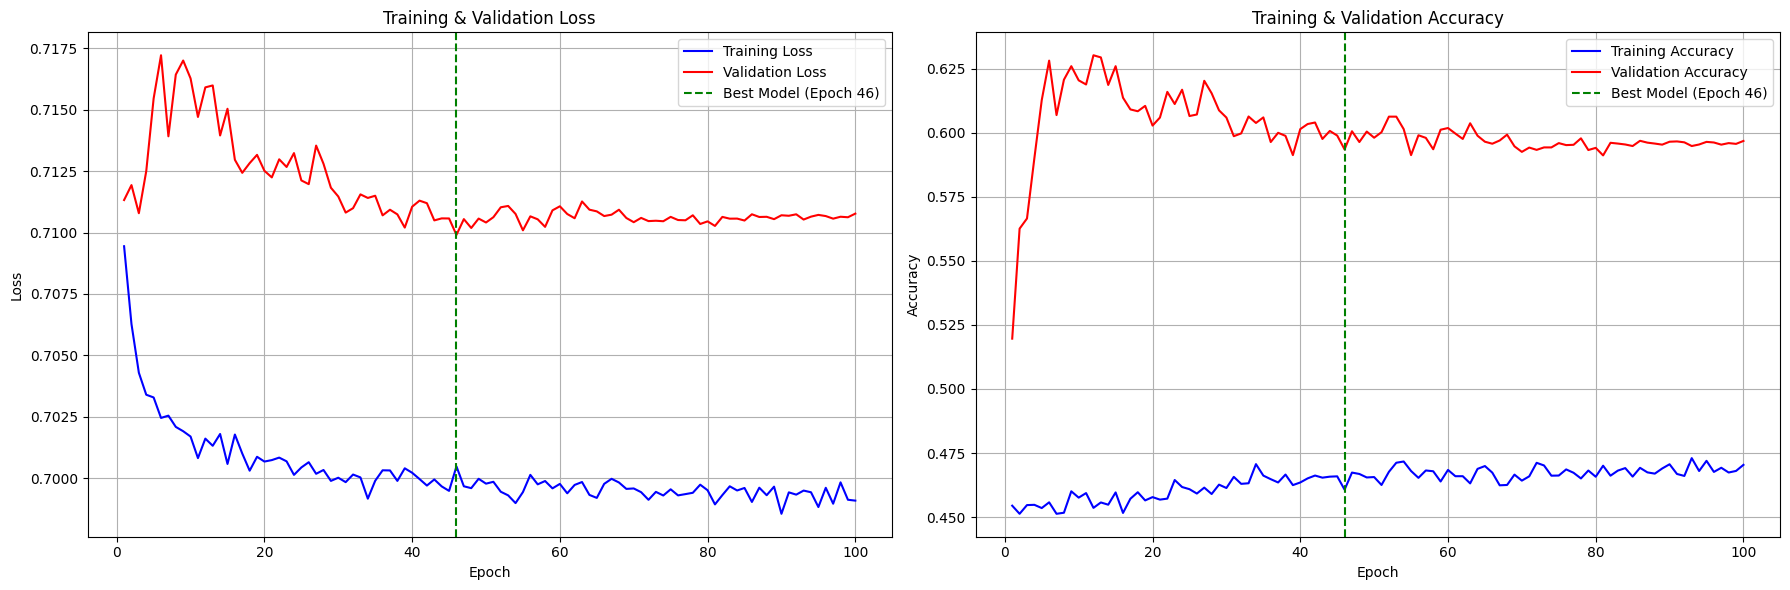

In [ ]:
# --- 2. 顯示 "最佳模型" 的訓練曲線 ---
print(f"\n--- 最佳模型的訓練曲線 (LR = {best_lr}) ---")
plot_training_curves(best_history, best_epoch_num)


--- 最佳模型的最終評估報告 (on Validation Set) ---
正在進行推論與評估...

Classification Report (Per Stock Instance)
              precision    recall  f1-score   support

   Not Top-9       0.69      0.74      0.71     11305
       Top-9       0.34      0.29      0.31      5355

    accuracy                           0.59     16660
   macro avg       0.51      0.51      0.51     16660
weighted avg       0.58      0.59      0.58     16660


Confusion Matrix


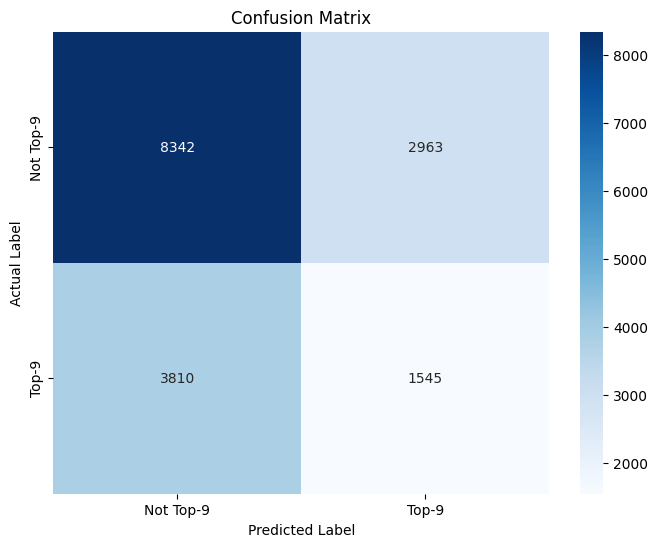


ROC Curve


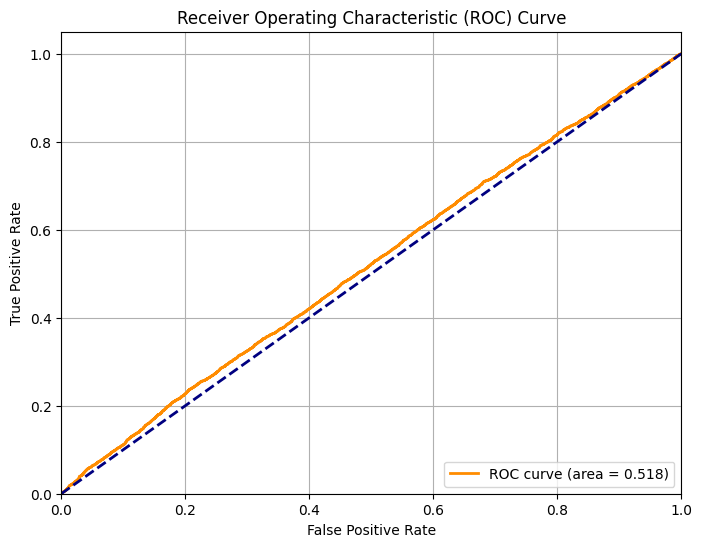

In [ ]:
# --- 3. 產生 "最佳模型" 的完整評估報告 ---
print(f"\n--- 最佳模型的最終評估報告 (on Validation Set) ---")
# 我們使用 val_dataset 進行最終評估
generate_evaluation_report(final_model, val_dataset, batch_size=batch_size)

# 🛠️ 載入訓練好的GCN模型

In [ ]:
# 1. 重新實例化模型結構
final_model = GCNModel_Part2()

# 2. 載入最佳參數
final_model.load_state_dict(best_model_state)

# 3. 搬移到 GPU (如果有的話)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
final_model = final_model.to(device)

# 4. 設定為評估模式 (這步非常重要，會關閉 Dropout 和 BatchNorm 的訓練行為)
final_model.eval()

print("最佳模型載入完成，準備進行評估。")

最佳模型載入完成，準備進行評估。


In [ ]:
# --- 載入資料 ---
# 資料路徑 (Data_OHLC):
_subfolder_o = os.path.join(PROJECT_PATH, "Data_OHLC")
MST_output_dir = os.path.join(PROJECT_PATH, "MST_data")

print(f"從 {_subfolder_o} 載入資料...")
# X_test
X_test_N_t = np.load(os.path.join(MST_output_dir, 'N_t_test_y9.npy'))
X_test_A_t = np.load(os.path.join(MST_output_dir, 'A_t_test_y9.npy'))
# y_test
y_test_0 = pd.read_csv(os.path.join(_subfolder_o, 'y_test_0.csv'))
y_test_1 = pd.read_csv(os.path.join(_subfolder_o, 'y_test_1.csv'))
y_test_2 = pd.read_csv(os.path.join(_subfolder_o, 'y_test_2.csv'))
y_test_3 = pd.read_csv(os.path.join(_subfolder_o, 'y_test_3.csv'))
y_test_4 = pd.read_csv(os.path.join(_subfolder_o, 'y_test_4.csv'))

print("✅ 資料載入完成。")

print(f"X_test_N_t shape: {X_test_N_t.shape}")
print(f"X_test_A_t shape: {X_test_A_t.shape}")
print(f"y_test_0 shape: {y_test_0.shape}")
print(f"y_test_1 shape: {y_test_1.shape}")
print(f"y_test_2 shape: {y_test_2.shape}")
print(f"y_test_3 shape: {y_test_3.shape}")
print(f"y_test_4 shape: {y_test_4.shape}")

從 /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/Data_OHLC 載入資料...
✅ 資料載入完成。
X_test_N_t shape: (5, 734, 28, 256)
X_test_A_t shape: (5, 734, 28, 28)
y_test_0 shape: (20552, 3)
y_test_1 shape: (20552, 3)
y_test_2 shape: (20552, 3)
y_test_3 shape: (20552, 3)
y_test_4 shape: (20552, 3)


In [ ]:
# 確保模型在評估模式
model.eval()
BATCH_SIZE = 64

# 準備 5 組 y_test
y_test_list = [y_test_0, y_test_1, y_test_2, y_test_3, y_test_4]
final_matrix_list = [] # 用來存 5 個 (28, 734) 的矩陣

print("\n=== 開始推論與維度轉換 ===")
Mode = "top_k"
# Mode = "threshold"

for i in range(5):
    # --- A. 準備 X (N_t, A_t) ---
    # 取出第 i 個測試集的 N_t 和 A_t
    # X_test_N_t shape: (5, 734, 28, 256) -> (734, 28, 256)
    # X_test_A_t shape: (5, 734, 28, 28)  -> (734, 28, 28)
    current_Nt = X_test_N_t[i]
    current_At = X_test_A_t[i]

    # 轉為 Tensor
    tensor_Nt = torch.tensor(current_Nt, dtype=torch.float32)
    tensor_At = torch.tensor(current_At, dtype=torch.float32)

    # --- B. 準備 y (產生 Label) ---
    current_y_df = y_test_list[i].copy()
    current_y_df.columns = ['TradeDate', 'Ticker', 'Return_5D']

    # 根據 Mode 產生 0/1 Label
    if Mode == "top_k":
        # 每天前 9 名為 1
        current_y_df['rank'] = current_y_df.groupby('TradeDate')['Return_5D'].rank(ascending=False, method='first')
        current_y_df['label'] = (current_y_df['rank'] <= 9).astype(int)
    elif Mode == "threshold":
        # 漲幅 > 0.3% 為 1
        current_y_df['label'] = (current_y_df['Return_5D'] >= 0.003).astype(int)
    else:
        raise ValueError(f"未知的 Mode: {Mode}")

    # Reshape y: (Total_Rows,) -> (Days, Stocks) -> (734, 28)
    # 注意：這裡假設 y 的排序是 (Day1_Stock1...Stock28, Day2...)，與 N_t 的順序一致
    num_samples = current_Nt.shape[0] # 734
    num_nodes = current_Nt.shape[1]   # 28

    # 防呆檢查
    assert len(current_y_df) == num_samples * num_nodes, "y 的長度與 X 不匹配！"

    y_reshaped = current_y_df['label'].values.reshape(num_samples, num_nodes)
    tensor_y = torch.tensor(y_reshaped, dtype=torch.long)

    # --- C. DataLoader ---
    dataset = TensorDataset(tensor_Nt, tensor_At, tensor_y)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --- D. 推論 (Inference) ---
    set_probs = [] # 存預測機率
    set_preds = [] # 存預測類別

    with torch.no_grad():
        for b_Nt, b_At, b_y in tqdm(loader, desc=f"Test Set {i}"):
            b_Nt = b_Nt.to(device)
            b_At = b_At.to(device)

            # GCN Forward: 輸入 N_t 和 A_t
            outputs = final_model(b_Nt, b_At)
            # outputs shape: (Batch, 28, 2) -> (Batch, Nodes, Classes)

            # 取得 "類別 1 (漲/Top-k)" 的機率
            # shape: (Batch, 28)
            probs = outputs[:, :, 1]

            # 取得預測類別 (0或1)
            preds = torch.argmax(outputs, dim=2)

            # 展平並存入 list (Batch * 28)
            set_probs.extend(probs.view(-1).cpu().numpy())
            set_preds.extend(preds.view(-1).cpu().numpy())

    # 計算該 Set 的準確度 (Optional)
    acc = accuracy_score(tensor_y.view(-1).numpy(), set_preds)
    print(f"Set {i} Accuracy : {acc:.4f}")

    # --- E. 轉換維度至 (28, 734) ---
    # set_probs 目前是一維長度 (734 * 28)
    # 1. Reshape 回 (天數, 股票數) -> (734, 28)
    prob_matrix_T_N = np.array(set_probs).reshape(num_samples, num_nodes)

    # 2. Transpose 成 (股票數, 天數) -> (28, 734)
    prob_matrix_N_T = prob_matrix_T_N.T

    final_matrix_list.append(prob_matrix_N_T)
    print(f"Set {i} Output Shape: {prob_matrix_N_T.shape}")

print("\n=== 所有測試集推論完成 ===")


=== 開始推論與維度轉換 ===


Test Set 0: 100%|██████████| 12/12 [00:00<00:00, 200.23it/s]


Set 0 Accuracy : 0.3215
Set 0 Output Shape: (28, 734)


Test Set 1: 100%|██████████| 12/12 [00:00<00:00, 233.72it/s]

Set 1 Accuracy : 0.3217
Set 1 Output Shape: (28, 734)



Test Set 2: 100%|██████████| 12/12 [00:00<00:00, 202.76it/s]


Set 2 Accuracy : 0.3215
Set 2 Output Shape: (28, 734)


Test Set 3: 100%|██████████| 12/12 [00:00<00:00, 213.88it/s]


Set 3 Accuracy : 0.3218
Set 3 Output Shape: (28, 734)


Test Set 4: 100%|██████████| 12/12 [00:00<00:00, 241.74it/s]


Set 4 Accuracy : 0.3216
Set 4 Output Shape: (28, 734)

=== 所有測試集推論完成 ===


In [ ]:
# 第0組，28支股票，在第0天的機率
print(final_matrix_list[0][:,0])

[0.9519489  0.86313134 0.8783536  0.90532196 0.9625638  0.8539305
 0.92608625 0.9088581  0.94624025 0.8671945  0.92071897 0.903041
 0.9599298  0.91897583 0.9210449  0.9542056  0.90961146 0.9345339
 0.92714566 0.9423739  0.93102044 0.90133494 0.8925669  0.89894474
 0.9667222  0.92900074 0.8264646  0.8951429 ]


# 🛠️ Trading

In [ ]:
all_predictions = np.array(final_matrix_list)
print(f"準備好的資料形狀(預期5*28*T): {all_predictions.shape}")

準備好的資料形狀(預期5*28*T): (5, 28, 734)


In [ ]:
# 儲存檔案
PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project"

GCN_testset_output = os.path.join(PROJECT_PATH, "GCN_testset_output")
os.makedirs(GCN_testset_output, exist_ok=True)

# 1. 轉換成一個大的 Numpy Array
# 形狀會從 List 變成 (5, 28, 734) 的 Array
all_predictions = np.array(final_matrix_list)

# 2. 設定檔名與儲存
npy_path = os.path.join(GCN_testset_output, "GCN_output_Quantile.npy")
np.save(npy_path, all_predictions)

print(f"✅ 已儲存為 .npy 檔: {npy_path}")
print(f"儲存後的形狀: {all_predictions.shape}")

✅ 已儲存為 .npy 檔: /content/drive/MyDrive/Colab Notebooks/電腦視覺之深度學習/final_project/GCN_testset_output/GCN_output_Quantile.npy
儲存後的形狀: (5, 28, 734)


資料轉換完成。共處理 5 個測試集。
單一測試集形狀範例: (28, 734)
------------------------------
個別測試集累積報酬率 (Cumulative Return):
Set 0: 526.51%
Set 1: 57.15%
Set 2: -9.88%
Set 3: -35.31%
Set 4: 68.62%
------------------------------
策略回測計算完成！
最終平均累積報酬率: 121.42%


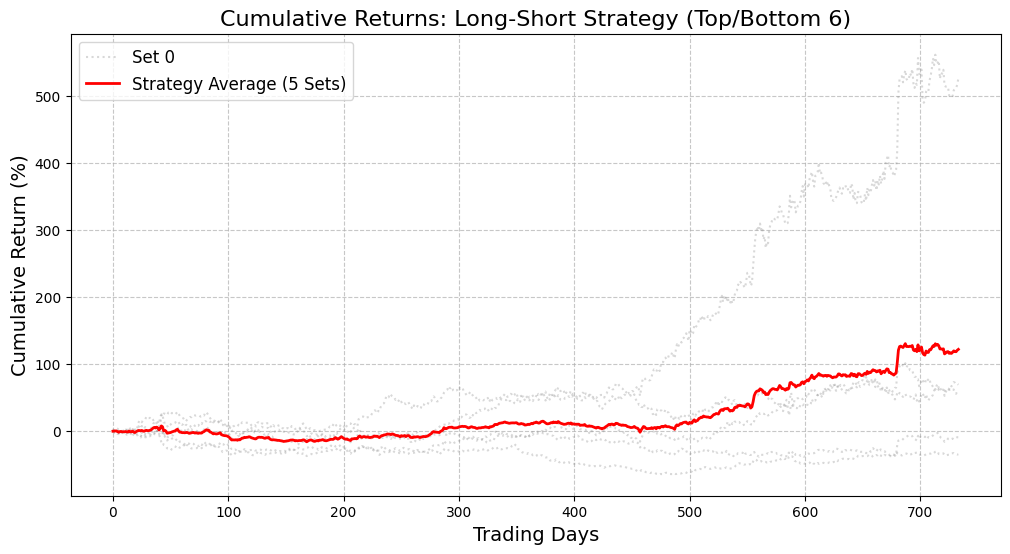

In [ ]:
# @title Trading Strategy Implementation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 參數設定 (參考 Trading.py)
# ==========================================
leg = 6           # 做多/做空 各選 6 支
weight_leg = 1.0 / leg
day_inv = 5       # 我們有 5 個測試集

# ==========================================
# 2. 資料格式轉換 (Data Formatting)
# ==========================================
# 我們需要將 Colab 中的 y_test (Long Format) 轉成 Trading.py 中的 Test (Wide Format: Index=Ticker, Col=Date)
# 同時也要把 final_matrix_list 轉成對應的 DataFrame

Test_Wide = []       # 存真實回報 (Wide Format)
Predicts_Prob_DF = [] # 存預測機率 (Wide Format)

# y_test_list 來自您上一段程式碼定義的 [y_test_0, y_test_1, ...]
for k, df in enumerate(y_test_list):
    # --- 處理真實回報 (Ground Truth) ---
    # 確保欄位名稱正確
    df = df.copy()
    df.columns = ['TradeDate', 'Ticker', 'Return_5D']

    # 轉置成 (Ticker x Date)
    # 這樣每一行是一個時間點，每一列是一支股票
    wide_gt = df.pivot(index='Ticker', columns='TradeDate', values='Return_5D')
    Test_Wide.append(wide_gt)

    # --- 處理預測機率 (Predictions) ---
    # final_matrix_list[k] 是 (28, T) 的 NumPy Array
    # 我們直接用 wide_gt 的 index (Ticker) 和 columns (Date) 來賦予它標籤
    # 注意：final_matrix_list 必須是 (Stocks, Dates) 形狀，您之前的程式碼最後是 .T 轉置過的，應該是 (28, 734) 正確
    prob_df = pd.DataFrame(
        final_matrix_list[k],
        index=wide_gt.index,
        columns=wide_gt.columns
    )
    Predicts_Prob_DF.append(prob_df)

print(f"資料轉換完成。共處理 {len(Test_Wide)} 個測試集。")
print(f"單一測試集形狀範例: {Test_Wide[0].shape}")

# ==========================================
# 3. 計算最佳權重 (Optimal Weight Calculation)
# ==========================================
OptWeights = []

for k, df_prob in enumerate(Predicts_Prob_DF):

    # 建立一個全 0 的權重矩陣
    weight_matrix = pd.DataFrame(0.0, index=df_prob.index, columns=df_prob.columns)

    # 針對每一天 (column) 進行迴圈
    for date in df_prob.columns:
        # 取出當天的預測機率
        prob_series = df_prob[date]

        # 找出機率最高的 6 支 (Long) 和 最低的 6 支 (Short)
        # 注意：如果不滿 12 支股票，這裡可能會有重疊，但資料集是 28 支所以沒問題
        long_stocks = prob_series.nlargest(leg).index
        short_stocks = prob_series.nsmallest(leg).index

        # 填入權重
        weight_matrix.loc[long_stocks, date] = weight_leg
        weight_matrix.loc[short_stocks, date] = -weight_leg

    OptWeights.append(weight_matrix)

# ==========================================
# 4. 計算投資組合回報 (Portfolio Returns)
# ==========================================
Rets_Inv = []

for k in range(day_inv):
    # 權重 * 真實回報 = 個股貢獻度
    _ret = OptWeights[k] * Test_Wide[k]

    # 加總所有股票的貢獻度 = 當期投資組合回報
    _ret_p = _ret.sum(axis=0)

    # 計算累積回報 (Compound Return)
    _ret_p = pd.DataFrame(_ret_p, columns=['HoldPeriod_Return'])

    # 這裡簡單處理：直接計算累積報酬，不進行複雜的 T+4 日期位移 (因 Colab 環境可能缺乏完整的 TrueDates 日曆)
    # 如果需要精確的 T+4 畫圖，需要額外的交易日曆資料
    _ret_p['Cumulative_Return'] = (1 + _ret_p['HoldPeriod_Return']).cumprod() - 1

    # 確保 Index 是 datetime 格式以便畫圖
    _ret_p.index = pd.to_datetime(_ret_p.index)

    Rets_Inv.append(_ret_p)

# ==========================================
# 5. 計算平均累積回報 (Total Average)
# ==========================================
# 將 5 個 Set 的 Cumulative_Return 合併
Ret_Avg = pd.concat(
    [df['Cumulative_Return'].reset_index(drop=True) for df in Rets_Inv],
    axis=1
)

# 計算平均
Ret_Avg['Strategy Average'] = Ret_Avg.mean(axis=1)

# 把 Index 設回第一個 Set 的日期 (僅供視覺化參考時間軸，因為 5 個 Set 時間其實不同)
# 這裡主要看的是 "經過多少個交易日" 的表現
Ret_Avg.index = range(len(Ret_Avg))

# --- 新增：印出個別回報 ---
print("-" * 30)
print("個別測試集累積報酬率 (Cumulative Return):")
for k, df in enumerate(Rets_Inv):
    # 取出最後一天的累積報酬
    final_ret = df['Cumulative_Return'].iloc[-1]
    print(f"Set {k}: {final_ret*100:.2f}%")
print("-" * 30)
# ------------------------

print("策略回測計算完成！")
print(f"最終平均累積報酬率: {Ret_Avg['Strategy Average'].iloc[-1]*100:.2f}%")

# ==========================================
# 6. 視覺化 (Visualization)
# ==========================================
plt.figure(figsize=(12, 6))

# 畫出 5 條個別的線 (灰色/細線)
for k, df in enumerate(Rets_Inv):
    # 為了放在同一張圖比較，我們用 "天數 (Days)" 當 X 軸，而不是絕對日期
    plt.plot(range(len(df)), df['Cumulative_Return'] * 100,
             color='gray', alpha=0.3, linestyle=':', label=f'Set {k}' if k==0 else "")

# 畫出平均線 (紅色/粗線)
plt.plot(Ret_Avg.index, Ret_Avg['Strategy Average'] * 100,
         color='red', linewidth=2, label='Strategy Average (5 Sets)')

plt.title('Cumulative Returns: Long-Short Strategy (Top/Bottom 6)', fontsize=16)
plt.xlabel('Trading Days', fontsize=14)
plt.ylabel('Cumulative Return (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 紀錄"5 個 Set 的平均累積報酬"

In [ ]:
print("-" * 30)
print(Mode)
print(learning_rates)
print(class_weight)
print("個別測試集累積報酬率 (Cumulative Return):")
for k, df in enumerate(Rets_Inv):
    # 取出最後一天的累積報酬
    final_ret = df['Cumulative_Return'].iloc[-1]
    print(f"Set {k}: {final_ret*100:.2f}%")
print("-" * 30)
for k, df in enumerate(Rets_Inv):
    # 取出最後一天的累積報酬
    final_ret = df['Cumulative_Return'].iloc[-1]
    print(f"|{final_ret*100:.2f}%",end='')
print(end='\n')
print("-" * 30)
# ------------------------

print("策略回測計算完成！")
print(f"最終平均累積報酬率: {Ret_Avg['Strategy Average'].iloc[-1]*100:.2f}%")
print(f"\n Grid Search 完成：最佳 LR={best_lr}, 最佳 Val Loss={best_val_loss:.6f}, (在 Epoch {best_epoch_num+1})")

------------------------------
top_k
[5e-05]
[1.0, 2.111111111111111]
個別測試集累積報酬率 (Cumulative Return):
Set 0: 526.51%
Set 1: 57.15%
Set 2: -9.88%
Set 3: -35.31%
Set 4: 68.62%
------------------------------
|526.51%|57.15%|-9.88%|-35.31%|68.62%
------------------------------
策略回測計算完成！
最終平均累積報酬率: 121.42%

 Grid Search 完成：最佳 LR=5e-05, 最佳 Val Loss=0.709902, (在 Epoch 46)


> **Quantile :**
>
> LR : [1e-4 ,7.5e-5 ,5e-5 ,2.5e-5 ,1e-5]
>
> $\Delta LR \;，\; Given\;W = 19/9$
> | LR  | Average Return |set0|set1|set2|set3|set4| Val Loss | Epoch k(共100) |
> |------------|--------|--------|--------|--------|--------|--------|--------|--------|
> |  1e-4 | 68.41% |284.11%|46.38%|38.46%|-41.90%|15.00%|0.707|31|
> |  7.5e-5 | 87.38% |399.32%|26.27%|-28.94%|-31.57%|71.80%|0.708|31|
> |  5e-5 | 121.42%👍 |526.51%|57.15%|-9.88%|-35.31%|68.62%|0.710|46|
> |  2.5e-5 | 18.53% |12.62%|17.65%|-53.51%|-46.81%|162.72%|0.710|3|
> |  1e-5 | 27.12% |25.16%|46.29%|-52.17%|-47.88%|164.19%|0.710|7|

#